# Wildfire Risk - Model
__Team 3 - Dave Friesen, John Chen, and Kyle Dalope__<br>
__ADS-508-02-SP23__<br><br>
__GitHub link: https://github.com/davefriesen/wildfire-risk__

In [12]:
__authors__ = ['Dave Friesen', 'John Chen', 'Kyle Dalope']
__contact__ = ['dfriesen@sandiego.edu', 'johnchen@sandiego.edu', 'kdalope@sandiego.edu']
__date__ = '2023-03-20'
__license__ = 'MIT'
__version__ = '1.0.1'

# Setup Basics

In [13]:
#Install
!pip install -q smclarify==0.1
!pip install --disable-pip-version-check -q PyAthena==2.1.0

# Import basic libraries
import boto3
import sagemaker

# Import data access libraries
from pyathena import connect
from smclarify.bias import report
from typing import Dict
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sagemaker

In [14]:
# Establish session fundamentals
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
#account_id = boto3.Session().client(service_name='sagemaker', region_name=region)

In [15]:
%store

Stored variables and their in-db values:
autopilot_train_s3_uri                                -> 's3://sagemaker-us-east-1-857283526476/data/amazon
balanced_bias_data_jsonlines_s3_uri                   -> 's3://sagemaker-us-east-1-857283526476/bias-detect
balanced_bias_data_s3_uri                             -> 's3://sagemaker-us-east-1-857283526476/bias-detect
bias_data_s3_uri                                      -> 's3://sagemaker-us-east-1-857283526476/bias-detect
ingest_create_athena_db_passed                        -> True
ingest_create_athena_table_parquet_passed             -> True
ingest_create_athena_table_passed                     -> True
ingest_create_athena_table_tsv_passed                 -> True
s3_private_path                                       -> 's3://sagemaker-us-east-1-857283526476/widfire-ris
s3_private_path_tsv                                   -> 's3://sagemaker-us-east-1-857283526476/amazon-revi
s3_public_path                                        -> 's3://

# Get Data from S3

In [16]:
import pandas as pd

data = pd.read_csv("../data/merged.csv", low_memory=False)
data.head()

,STATION,LATITUDE,LONGITUDE,ELEVATION,NAME,CDSD,CDSD_ATTRIBUTES,CLDD,CLDD_ATTRIBUTES,DT00,...,InitialLatitude,InitialLongitude,IsFireCauseInvestigated,IsTrespass,POOCity,POOState,PredominantFuelModel,PrimaryFuelModel,ym_date,fire
0,USR0000CABS,40.3983,-122.8333,579.1,"ARBUCKLE BASIN CALIFORNIA, CA US",0.0,NaN,0.0,",U",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,USR0000CABS,40.3983,-122.8333,579.1,"ARBUCKLE BASIN CALIFORNIA, CA US",0.0,NaN,0.0,",U",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,USR0000CABS,40.3983,-122.8333,579.1,"ARBUCKLE BASIN CALIFORNIA, CA US",0.0,NaN,0.0,",U",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,USR0000CABS,40.3983,-122.8333,579.1,"ARBUCKLE BASIN CALIFORNIA, CA US",0.0,NaN,0.0,",U",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,USR0000CABS,40.3983,-122.8333,579.1,"ARBUCKLE BASIN CALIFORNIA, CA US",0.0,NaN,0.0,",U",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


# Detecting Bias with Amazon SageMaker Clarify

SageMaker Clarify helps you detect possible pre- and post-training biases using a variety of metrics.

In [17]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.c5.xlarge", 
    sagemaker_session=sess
)

# Writing DataConfig
A DataConfig object communicates some basic information about data I/O to Clarify. We specify where to find the input dataset, where to store the output, the target column (label), the header names, and the dataset type.

In [18]:
bias_report_output_path = "s3://{}/data".format(bucket)

bias_data_config = clarify.DataConfig(
    s3_data_input_path='../data/merged.csv',
    s3_output_path=bias_report_output_path,
    label="fire",
    headers=data.columns.to_list(),
    dataset_type="text/csv",
)

## Writing BiasConfig
SageMaker Clarify also needs information on what the sensitive columns (`facets`) are, what the sensitive features (`facet_values_or_threshold`) may be, and what the desirable outcomes are (`label_values_or_threshold`).
Clarify can handle both categorical and continuous data for `facet_values_or_threshold` and for `label_values_or_threshold`. In this case we are using categorical data.

We specify this information in the `BiasConfig` API. Here that the positive outcome is `star rating==5`, `product_category` is the sensitive column, and `Gift Card` is the sensitive value.

In [19]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1],
    facet_name="geohash",
    facet_values_or_threshold=["PDX"],                           
)

## Detect Bias with a SageMaker Processing Job and Clarify

In [20]:
clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

INFO:sagemaker:Creating processing-job with name Clarify-Pretraining-Bias-2023-03-30-03-28-34-105


In [21]:
run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name

'Clarify-Pretraining-Bias-2023-03-30-03-28-34-105'

In [22]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)

In [23]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)

In [24]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, run_pre_training_bias_processing_job_name, region
        )
    )
)

In [25]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=run_pre_training_bias_processing_job_name, sagemaker_session=sess
)

processing_job_description = running_processor.describe()

print(processing_job_description)

{'ProcessingInputs': [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-857283526476/Clarify-Pretraining-Bias-2023-03-30-03-28-34-105/input/dataset/merged.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-857283526476/data/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}], 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'analysis_result', 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-857283526476/data', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}, 'AppManaged': False}]}, 'ProcessingJobName': 'Clarify-Pretraining-Bias-2023-03-30-03-28-34-105', 

In [26]:
running_processor.wait(logs=False)

......................................................................!

# Download Report From S3
The class-imbalance metric should match the value calculated for the unbalanced dataset using the open source version above.

In [27]:
!aws s3 ls $bias_report_output_path/

2023-03-24 18:49:50   13673831 amazon_reviews_us_Digital_Software_v1_00_autopilot.csv
2023-03-30 03:34:25       2501 analysis.json
2023-03-30 03:28:35       1628 analysis_config.json
2023-03-30 03:34:25     613317 report.html
2023-03-30 03:34:25     342369 report.ipynb
2023-03-30 03:34:25     326695 report.pdf
2023-03-30 02:59:43    1046329 wildfire_risk_autopilot.csv


In [28]:
!aws s3 cp --recursive $bias_report_output_path ./generated_bias_report/

download: s3://sagemaker-us-east-1-857283526476/data/analysis_config.json to generated_bias_report/analysis_config.json
download: s3://sagemaker-us-east-1-857283526476/data/analysis.json to generated_bias_report/analysis.json
download: s3://sagemaker-us-east-1-857283526476/data/report.ipynb to generated_bias_report/report.ipynb
download: s3://sagemaker-us-east-1-857283526476/data/report.pdf to generated_bias_report/report.pdf
download: s3://sagemaker-us-east-1-857283526476/data/report.html to generated_bias_report/report.html
download: s3://sagemaker-us-east-1-857283526476/data/wildfire_risk_autopilot.csv to generated_bias_report/wildfire_risk_autopilot.csv
download: s3://sagemaker-us-east-1-857283526476/data/amazon_reviews_us_Digital_Software_v1_00_autopilot.csv to generated_bias_report/amazon_reviews_us_Digital_Software_v1_00_autopilot.csv


In [29]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./generated_bias_report/report.html">Bias Report</a></b>'))

# Balance the Dataset

In [30]:
print("Shape of dataframe before splitting {}".format(data.shape))

Shape of dataframe before splitting (42289, 89)


In [31]:
# Balance the dataset down to the minority class
df_grouped_by = data.groupby(["fire"]) 
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))

df_balanced = df_balanced.reset_index(drop=True)
print("Shape of balanced dataframe {}".format(df_balanced.shape))

Shape of balanced dataframe (19460, 89)


# Split the Data into Train, Validation, and Test Sets

In [32]:
from sklearn.model_selection import train_test_split

# Split all data into 90% train and 10% holdout
df_train, df_holdout = train_test_split(df_balanced, test_size=0.10, stratify=df_balanced["fire"])

# Split holdout data into 50% validation and 50% test
df_validation, df_test = train_test_split(df_holdout, test_size=0.50, stratify=df_holdout["fire"])

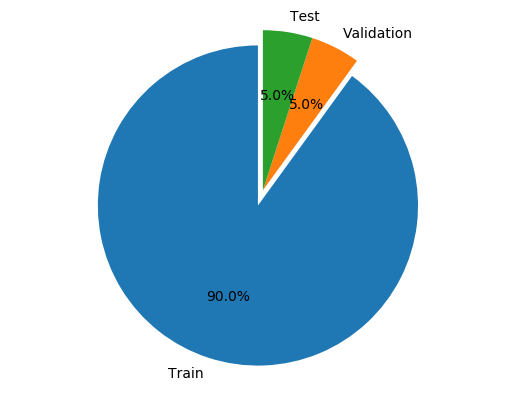

In [33]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Train", "Validation", "Test"]
sizes = [len(df_train.index), len(df_validation.index), len(df_test.index)]
explode = (0.1, 0, 0)

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct="%1.1f%%", startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis("equal")

plt.show()

# Show 90% Train, 5% Validation, and 5% Test Data Split

In [34]:
df_train.shape

(17514, 89)

In [35]:
df_validation.shape

(973, 89)

In [36]:
df_test.shape

(973, 89)

In [37]:
df_train = df_train[["fire", "ContainmentDateTime", "ControlDateTime", "DiscoveryAcres", "FireCause", "FireDiscoveryDateTime", "FireOutDateTime", "POOState", "InitialLatitude", "InitialLongitude", "GACC"]]
df_train.shape

(17514, 11)

In [38]:
df_train.head(5)

,fire,ContainmentDateTime,ControlDateTime,DiscoveryAcres,FireCause,FireDiscoveryDateTime,FireOutDateTime,POOState,InitialLatitude,InitialLongitude,GACC
13477,1.0,NaN,NaN,0.1,Unknown,2019/07/05 03:30:08+00,NaN,US-CA,34.409520,-118.457020,OSCC
12086,1.0,NaN,NaN,0.1,Unknown,2019/09/01 19:05:06+00,NaN,US-CA,37.064037,-119.508731,OSCC
17090,1.0,2018/02/18 21:00:00+00,2018/02/18 21:04:59+00,0.1,Human,2018/02/18 19:38:00+00,2018/10/12 18:59:59+00,US-CA,37.783830,-119.072300,OSCC
14211,1.0,NaN,NaN,0.1,Unknown,2018/08/11 12:37:48+00,NaN,US-CA,34.151110,-118.693890,OSCC
2178,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
#Write a Train csv with Header for Autopilot
autopilot_train_path = "./wildfire_risk_autopilot.csv"
df_train.to_csv(autopilot_train_path, index=False, header=True)

In [40]:
train_s3_prefix = "data"
autopilot_train_s3_wf = sess.upload_data(path=autopilot_train_path, key_prefix=train_s3_prefix)
autopilot_train_s3_wf

's3://sagemaker-us-east-1-857283526476/data/wildfire_risk_autopilot.csv'

In [41]:
!aws s3 ls $autopilot_train_s3_wf

2023-03-30 03:34:37    1045513 wildfire_risk_autopilot.csv


# Store Variables and Close Session

In [42]:
# Store variables for subsequent notebooks
%store autopilot_train_s3_wf

%store

Stored 'autopilot_train_s3_wf' (str)
Stored variables and their in-db values:
autopilot_train_s3_uri                                -> 's3://sagemaker-us-east-1-857283526476/data/amazon
autopilot_train_s3_wf                                 -> 's3://sagemaker-us-east-1-857283526476/data/wildfi
balanced_bias_data_jsonlines_s3_uri                   -> 's3://sagemaker-us-east-1-857283526476/bias-detect
balanced_bias_data_s3_uri                             -> 's3://sagemaker-us-east-1-857283526476/bias-detect
bias_data_s3_uri                                      -> 's3://sagemaker-us-east-1-857283526476/bias-detect
ingest_create_athena_db_passed                        -> True
ingest_create_athena_table_parquet_passed             -> True
ingest_create_athena_table_passed                     -> True
ingest_create_athena_table_tsv_passed                 -> True
s3_private_path                                       -> 's3://sagemaker-us-east-1-857283526476/widfire-ris
s3_private_path_tsv       

In [43]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [44]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>